In [1]:
"""
Jupyter Drive: https://github.com/jupyter/jupyter-drive

Install:
$ git clone git://github.com/jupyter/jupyter-drive.git
$ pip install -e jupyter-drive

Activate:
$ python -m jupyterdrive

Deactivate:
$ python -m jupyterdrive --deactivate
"""
# Requirements: numpy, sklearn, nltk, matplotlib, plotly

# For Retina Display
%config InlineBackend.figure_format = 'retina'

# Prevent codes being displayed when exporting to an HTML file
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) {jQuery(".input_area").toggle(); jQuery(".prompt").toggle();} jQuery(".highlight").show();});</script>', raw=True)

# Dynamically add a button to show/hide codes
di.display_html("<script>jQuery(function() {jQuery(function() {var b = jQuery('<input type=\"button\" value=\"Show/Hide codes\"/>'); b.click(function(){jQuery('.input_area').each(function(){jQuery(this).toggle();});}); jQuery('#References').parent().append(b);});});</script>", raw=True)

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Project 1: Classification Analysis on Textual Data

### References
1. [The 20 newsgroups text dataset](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)
2. [Working With Text Data](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
<pre>
</pre>

## Dataset:
(Remove all headers, footers, and quotes.)

### Load the dataset for following categories

In [2]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

print(newsgroups_train.target_names)

['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']


### Plot the histogram

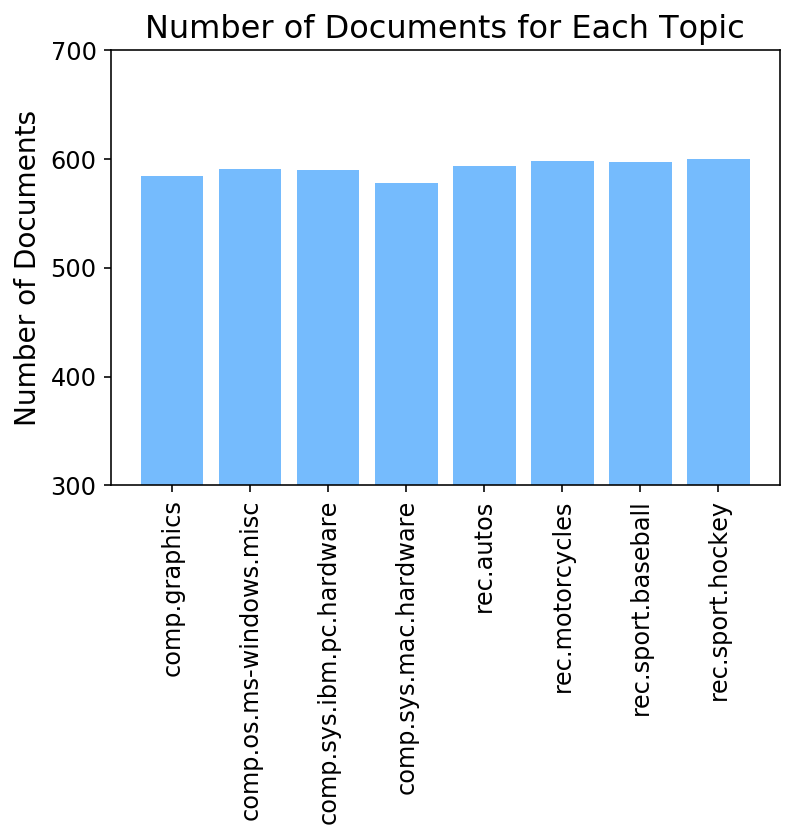

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

unique, counts = np.unique(newsgroups_train.target, return_counts=True)
# print(dict(zip(unique, counts)))
plt.bar(unique, counts, align='center', tick_label=newsgroups_train.target_names, color='xkcd:sky blue')
plt.title('Number of Documents for Each Topic')
plt.ylabel('Number of Documents')
plt.ylim([300,700])
plt.xticks(rotation='vertical')
plt.yticks(np.arange(300, 800, 100))
plt.show()

## Modeling Text Data and Feature Extraction:

### Tokenize and Stem

In [4]:
import nltk
from nltk.stem import PorterStemmer, SnowballStemmer
import string
# nltk.download('punkt')

stemmer = PorterStemmer()
# stemmer = SnowballStemmer('english')
def tokenize_and_stem(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token.strip(string.punctuation) for token in tokens if token.isalnum()]
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens
# print(newsgroups_train.data[1])
# print(tokenize_and_stem(newsgroups_train.data[1]))

### TFxIDF Vectors

In [5]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

min_df = 2
tfidfVectorizer = TfidfVectorizer(min_df=min_df, stop_words='english', tokenizer=tokenize_and_stem)
tfidfVectors = tfidfVectorizer.fit_transform(newsgroups_train.data)
print('When min_df=%d, we get %d documents with %d terms.' % (min_df, tfidfVectors.shape[0], tfidfVectors.shape[1]))

When min_df=2, we get 4732 documents with 12828 terms.


### TFxICF Vectors

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

newsgroups_tficf = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
categories_tficf = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
categories_tficf_id = []
for category_tficf in categories_tficf:
    categories_tficf_id.append(newsgroups_tficf.target_names.index(category_tficf))

text_group_by_class = ["" for i in range(20)]
for i in range(len(newsgroups_tficf.data)):
    text_group_by_class[newsgroups_tficf.target[i]] += (" " + newsgroups_tficf.data[i])

vectorizer = CountVectorizer(min_df=min_df, stop_words='english', tokenizer=tokenize_and_stem)
vectors = vectorizer.fit_transform(text_group_by_class)

transformer = TfidfTransformer()
tficfVectors = transformer.fit_transform(vectors)

def show_top10(vectors, vectorizer, categories, categories_ids):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(vectors.toarray()[categories_ids[i],:])[-10:][::-1]
        print("%24s: %s" % (category, ", ".join(feature_names[top10])))

print('When min_df=%d, the 10 most significant terms for each class are:\n' % min_df)
show_top10(tficfVectors, vectorizer, categories_tficf, categories_tficf_id)

When min_df=2, the 10 most significant terms for each class are:

comp.sys.ibm.pc.hardware: drive, thi, scsi, use, ide, card, disk, control, ani, bio
   comp.sys.mac.hardware: thi, mac, use, appl, drive, simm, problem, ha, scsi, quadra
            misc.forsale: 1, 2, thi, new, sale, offer, use, includ, ship, price
  soc.religion.christian: thi, god, wa, christian, jesu, hi, church, christ, peopl, say


## Feature Selection:

### LSI

In [7]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
lsiVectors = svd.fit_transform(tfidfVectors)

print('When min_df=%d, we get %d documents, each with a %d-dimensional feature vector.' % (min_df, lsiVectors.shape[0], lsiVectors.shape[1]))

When min_df=2, we get 4732 documents, each with a 50-dimensional feature vector.


### NMF

In [8]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=50, init='random', random_state=0)
nmfVectors = nmf.fit_transform(tfidfVectors)

print('When min_df=%d, we get %d documents, each with a %d-dimensional feature vector.' % (min_df, nmfVectors.shape[0], nmfVectors.shape[1]))

When min_df=2, we get 4732 documents, each with a 50-dimensional feature vector.


## Learning Algorithms:

### Combine data into two classes
'Computer Technology' <-- ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']

'Recreational Activity' <-- ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

# preprocessing pipeline
pp = Pipeline([('vect', tfidfVectorizer), ('dim_red', svd), ('norm', Normalizer(copy=False))])

x_train = pp.fit_transform(newsgroups_train.data)
x_test = pp.transform(newsgroups_test.data)

vfunc = np.vectorize(lambda t : t / 4)
y_train = vfunc(newsgroups_train.target)
y_test = vfunc(newsgroups_test.target)

# function for drawing ROC curves
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

def draw_roc_curve(fpr, tpr, roc_auc, name):
    data = []
    width, height = 800, 600
    
    if type(name) != list or len(name) == 1:
        width, height = 600, 450
        trace1 = go.Scatter(x=fpr, y=tpr, 
                            mode='lines', 
                            line=dict(color='darkorange', width=2),
                            name='%s (area = %0.2f)' % (name, roc_auc)
                           )
        data.append(trace1)
    else:
        for i in range(len(name)):
            trace1 = go.Scatter(x=fpr[i], y=tpr[i], 
                                mode='lines', 
                                line=dict(width=2),
                                name='%s (area = %0.2f)' % (name[i], roc_auc[i])
                               )
            data.append(trace1)
    
    trace2 = go.Scatter(x=[0, 1], y=[0, 1], 
                        mode='lines', 
                        line=dict(color='navy', width=2, dash='dash'),
                        showlegend=False)
    data.append(trace2)
    
    layout = go.Layout(title='Receiver Operating Characteristic',
                       autosize=False,
                       width=width,
                       height=height,
                       xaxis=dict(title='False Positive Rate', ticks='outside', mirror=True, linewidth=1),
                       yaxis=dict(title='True Positive Rate', ticks='outside', mirror=True, linewidth=1, range=[0, 1.05]),
                       legend=dict(x=.5, y=.05, bordercolor='#D3D3D3', borderwidth=1))
    
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

### SVM

#### Hard Margin SVM Classifier

In [10]:
from sklearn.svm import SVC

# hard margin SVM classifier
clf_svm1 = SVC(C=1000.0, kernel='linear')
clf_svm1.fit(x_train, y_train)
score = clf_svm1.decision_function(x_test)
predicted = clf_svm1.predict(x_test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, predicted, average='macro')))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, predicted, average='macro')))
print("Confusion Matrix: \n{0}".format(metrics.confusion_matrix(y_test, predicted)))

fpr_svm1, tpr_svm1, thresholds = metrics.roc_curve(y_test, score)
roc_auc_svm1 = metrics.auc(fpr_svm1, tpr_svm1)
draw_roc_curve(fpr_svm1, tpr_svm1, roc_auc_svm1, 'ROC curve')

Accuracy:    0.933333
Precision:   0.934091
Recall:      0.933146
Confusion Matrix: 
[[1425  135]
 [  75 1515]]


#### Soft Margin SVM Classifier

In [11]:
# soft margin SVM classifier
clf_svm2 = SVC(C=0.001, kernel='linear')
clf_svm2.fit(x_train, y_train)
score = clf_svm2.decision_function(x_test)
predicted = clf_svm2.predict(x_test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, predicted, average='macro')))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, predicted, average='macro')))
print("Confusion Matrix: \n{0}".format(metrics.confusion_matrix(y_test, predicted)))

fpr_svm2, tpr_svm2, thresholds = metrics.roc_curve(y_test, score)
roc_auc_svm2 = metrics.auc(fpr_svm2, tpr_svm2)
draw_roc_curve(fpr_svm2, tpr_svm2, roc_auc_svm2, 'ROC curve')

Accuracy:    0.504762
Precision:   0.252381
Recall:      0.500000
Confusion Matrix: 
[[   0 1560]
 [   0 1590]]


### Parameter Tuning Using Grid Search

In [12]:
from sklearn.model_selection import GridSearchCV
import math

parameters = {'C': [math.pow(10, k) for k in range(-3,4)]}

gs_clf = GridSearchCV(SVC(kernel='linear'), parameters, n_jobs=-1, cv=5)
gs_clf.fit(x_train, y_train)

print("Best Parameters: ")
print(gs_clf.best_params_)

score = gs_clf.decision_function(x_test)
predicted = gs_clf.predict(x_test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, predicted, average='macro')))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, predicted, average='macro')))
print("Confusion Matrix: \n{0}".format(metrics.confusion_matrix(y_test, predicted)))

fpr_svm, tpr_svm, thresholds = metrics.roc_curve(y_test, score)
roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)
draw_roc_curve(fpr_svm, tpr_svm, roc_auc_svm, 'ROC curve')

Best Parameters: 
{'C': 1.0}
Accuracy:    0.932063
Precision:   0.932772
Recall:      0.931882
Confusion Matrix: 
[[1424  136]
 [  78 1512]]


### Multinomial Naïve Bayes Classifier

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

clf_nb = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
clf_nb.fit(x_train, y_train)
score = clf_nb.predict_proba(x_test)[:,1]
predicted = clf_nb.predict(x_test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, predicted, average='macro')))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, predicted, average='macro')))
print("Confusion Matrix: \n{0}".format(metrics.confusion_matrix(y_test, predicted)))

fpr_nb, tpr_nb, thresholds = metrics.roc_curve(y_test, score)
roc_auc_nb = metrics.auc(fpr_nb, tpr_nb)
draw_roc_curve(fpr_nb, tpr_nb, roc_auc_nb, 'ROC curve')

Accuracy:    0.895556
Precision:   0.900580
Recall:      0.895029
Confusion Matrix: 
[[1310  250]
 [  79 1511]]


### Logistic Regression Classifier

In [14]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()
clf_lr.fit(x_train, y_train)
score = clf_lr.predict_proba(x_test)[:,1]
predicted = clf_lr.predict(x_test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, predicted, average='macro')))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, predicted, average='macro')))
print("Confusion Matrix: \n{0}".format(metrics.confusion_matrix(y_test, predicted)))

fpr_lr, tpr_lr, thresholds = metrics.roc_curve(y_test, score)
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)
draw_roc_curve(fpr_lr, tpr_lr, roc_auc_lr, 'ROC curve')

Accuracy:    0.928571
Precision:   0.929208
Recall:      0.928399
Confusion Matrix: 
[[1420  140]
 [  85 1505]]


### Logistic Regression Classifier with Regularization

In [15]:
# function to draw table
def draw_table(values, title):
    headerColor = '#4B87CB'
    rowEvenColor = '#C8D5EB'
    rowOddColor = '#E5EBF5'

    trace0 = go.Table(
        type = 'table',
        header = dict(
            values = [['<b>Penalty</b>'],
                      ['<b>C</b>'],
                      ['<b>Accuracy</b>'],
                      ['<b>Rank</b>']],
            line = dict(color = '#506784'),
            fill = dict(color = headerColor),
            align = ['center'],
            font = dict(color = 'white', size = 14)
        ),
        cells = dict(
            values = values,
            line = dict(color = '#506784'),
            fill = dict(color = [[rowOddColor if x % 2 == 0 else rowEvenColor for x in range(len(values[0]))]]),
            align = ['center'],
            font = dict(color = '#506784', size = 12),
            height = 30
        ))
    data = [trace0]

    layout = go.Layout(title=title, autosize=False, width=600, height=650)

    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig)

# grid search
parameters = {'penalty': ['l1', 'l2'], 
              'C': [math.pow(10, k) for k in range(-3,4)]}

gs_clf = GridSearchCV(LogisticRegression(), parameters, n_jobs=-1, cv=5)
gs_clf.fit(x_train, y_train)
score = gs_clf.predict_proba(x_test)[:,1]
predicted = gs_clf.predict(x_test)

values = [list(gs_clf.cv_results_['param_penalty']), 
          list(gs_clf.cv_results_['param_C']), 
          ["%.6f" % x for x in gs_clf.cv_results_['mean_test_score']], 
          list(gs_clf.cv_results_['rank_test_score'])]

draw_table(values, title='Logistic Regression Grid Search Scores')

print("\nBest Parameters: \n{0}\n".format(gs_clf.best_params_))
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, predicted, average='macro')))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, predicted, average='macro')))
print("Confusion Matrix: \n{0}".format(metrics.confusion_matrix(y_test, predicted)))

fpr_lr_best, tpr_lr_best, thresholds = metrics.roc_curve(y_test, score)
roc_auc_lr_best = metrics.auc(fpr_lr_best, tpr_lr_best)
draw_roc_curve(fpr_lr_best, tpr_lr_best, roc_auc_lr_best, 'ROC curve')


Best Parameters: 
{'penalty': 'l2', 'C': 1.0}

Accuracy:    0.928571
Precision:   0.929208
Recall:      0.928399
Confusion Matrix: 
[[1420  140]
 [  85 1505]]


### ROC Curves

In [16]:
fpr = [fpr_svm1, fpr_svm2, fpr_nb, fpr_lr, fpr_lr_best]
tpr = [tpr_svm1, tpr_svm2, tpr_nb, tpr_lr, tpr_lr_best]
roc_auc = [roc_auc_svm1, roc_auc_svm2, roc_auc_nb, roc_auc_lr, roc_auc_lr_best]
name = ['Hard Margin SVM', 'Soft Margin SVM', 'Multinomial Naive Bayes', 'Logistic Regression', 'Logistic Regression (Best)']
draw_roc_curve(fpr, tpr, roc_auc, name)

## Multiclass Classification:

### Load the dataset for following categories

In [17]:
print(categories_tficf)
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories_tficf, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories_tficf, remove=('headers', 'footers', 'quotes'))

x_train = pp.fit_transform(newsgroups_train.data)
x_test = pp.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target

['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']


### Naïve Bayes

In [18]:
clf_nb.fit(x_train, y_train)
predicted = clf_nb.predict(x_test)

print(metrics.classification_report(y_test, predicted,target_names=newsgroups_test.target_names))
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, predicted, average='macro')))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, predicted, average='macro')))
print("Confusion Matrix: \n{0}".format(metrics.confusion_matrix(y_test, predicted)))

                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.66      0.80      0.73       392
   comp.sys.mac.hardware       0.75      0.62      0.68       385
            misc.forsale       0.87      0.78      0.82       390
  soc.religion.christian       0.88      0.94      0.91       398

             avg / total       0.79      0.78      0.78      1565

Accuracy:    0.784665
Precision:   0.789425
Recall:      0.783319
Confusion Matrix: 
[[314  40  22  16]
 [105 237  21  22]
 [ 49  23 304  14]
 [  5  17   3 373]]


### Multiclass SVM - One VS One

In [19]:
clf = SVC(decision_function_shape='ovo')

clf.fit(x_train, y_train)
predicted = clf.predict(x_test)

print(metrics.classification_report(y_test, predicted,target_names=newsgroups_test.target_names))
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, predicted, average='macro')))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, predicted, average='macro')))
print("Confusion Matrix: \n{0}".format(metrics.confusion_matrix(y_test, predicted)))

                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.66      0.82      0.73       392
   comp.sys.mac.hardware       0.73      0.66      0.70       385
            misc.forsale       0.88      0.78      0.83       390
  soc.religion.christian       0.96      0.91      0.94       398

             avg / total       0.81      0.80      0.80      1565

Accuracy:    0.796805
Precision:   0.806761
Recall:      0.795750
Confusion Matrix: 
[[321  51  17   3]
 [105 256  17   7]
 [ 49  29 306   6]
 [ 11  15   8 364]]


### Multiclass SVM - One VS Rest

In [20]:
from sklearn.svm import LinearSVC

clf = LinearSVC()

clf.fit(x_train, y_train)
predicted = clf.predict(x_test)

print(metrics.classification_report(y_test, predicted,target_names=newsgroups_test.target_names))
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, predicted, average='macro')))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, predicted, average='macro')))
print("Confusion Matrix: \n{0}".format(metrics.confusion_matrix(y_test, predicted)))

                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.73      0.73      0.73       392
   comp.sys.mac.hardware       0.70      0.75      0.72       385
            misc.forsale       0.85      0.81      0.83       390
  soc.religion.christian       0.96      0.94      0.95       398

             avg / total       0.81      0.81      0.81      1565

Accuracy:    0.808307
Precision:   0.810544
Recall:      0.807526
Confusion Matrix: 
[[288  74  26   4]
 [ 68 287  23   7]
 [ 37  33 316   4]
 [  3  15   6 374]]
